In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
from struct import unpack
import matplotlib.pyplot as plt
import json
import glob
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output, Image, display, HTML

In [2]:
labels = ['camel', 'cat', 'cow', 'dog', 'horse', 'lion', 'mouse', 'pig', 'rabbit', 'sheep', 'tiger', 'zebra']
labels_to_idx = {label: idx for idx, label in enumerate(labels)}
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/%s.bin'
paths = {label: get_file(label + '.bin', base_url % label) for label in labels}
paths

{'camel': '/home/douwe/.keras/datasets/camel.bin',
 'cat': '/home/douwe/.keras/datasets/cat.bin',
 'cow': '/home/douwe/.keras/datasets/cow.bin',
 'dog': '/home/douwe/.keras/datasets/dog.bin',
 'horse': '/home/douwe/.keras/datasets/horse.bin',
 'lion': '/home/douwe/.keras/datasets/lion.bin',
 'mouse': '/home/douwe/.keras/datasets/mouse.bin',
 'pig': '/home/douwe/.keras/datasets/pig.bin',
 'rabbit': '/home/douwe/.keras/datasets/rabbit.bin',
 'sheep': '/home/douwe/.keras/datasets/sheep.bin',
 'tiger': '/home/douwe/.keras/datasets/tiger.bin',
 'zebra': '/home/douwe/.keras/datasets/zebra.bin'}

In [15]:
def load_icons(paths, train_size=0.85, max_per_class=10000):
    x = []
    y = []
    for label, path in paths.items():
        with open(path, 'rb') as f:
            while True:
                img = PIL.Image.new('L', (32, 32), 'white')
                draw = ImageDraw.Draw(img)
                header = f.read(15)
                if len(header) != 15:
                    break
                strokes, = unpack('H', f.read(2))
                for i in range(strokes):
                    n_points, = unpack('H', f.read(2))
                    fmt = str(n_points) + 'B'
                    read_scaled = lambda: (p // 8 for 
                                           p in unpack(fmt, f.read(n_points)))
                    points = [*zip(read_scaled(), read_scaled())]
                    draw.line(points, fill=0)
                img = img_to_array(img)
                x.append(img)
                y.append(labels_to_idx[label])
                if len(x) % max_per_class == 0:
                    break
    x = np.asarray(x) / 255
    y = np.asarray(y)
    return train_test_split(x, y, train_size=train_size)


x_train, x_test, y_train, y_test = load_icons(paths)
x_train.shape, x_test.shape

((102000, 32, 32, 1), (18000, 32, 32, 1))

In [13]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [16]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 102000 samples, validate on 18000 samples
Epoch 1/100
102000/102000 [==============================] - 10s - loss: 0.6226 - val_loss: 0.5540
Epoch 2/100
102000/102000 [==============================] - 7s - loss: 0.5006 - val_loss: 0.4565
Epoch 3/100
102000/102000 [==============================] - 7s - loss: 0.4300 - val_loss: 0.4106
Epoch 4/100
102000/102000 [==============================] - 7s - loss: 0.4004 - val_loss: 0.3816
Epoch 5/100
102000/102000 [==============================] - 7s - loss: 0.3638 - val_loss: 0.3481
Epoch 6/100
102000/102000 [==============================] - 7s - loss: 0.3388 - val_loss: 0.3284
Epoch 7/100
102000/102000 [==============================] - 7s - loss: 0.3218 - val_loss: 0.3150
Epoch 8/100
102000/102000 [==============================] - 8s - loss: 0.3096 - val_loss: 0.3051
Epoch 9/100
102000/102000 [==============================] - 7s - loss: 0.3001 - val_loss: 0.2970
Epoch 10/100
102000/102000 [==============================] - 7s -

102000/102000 [==============================] - 7s - loss: 0.2278 - val_loss: 0.2285
Epoch 84/100
102000/102000 [==============================] - 7s - loss: 0.2276 - val_loss: 0.2267
Epoch 85/100
102000/102000 [==============================] - 7s - loss: 0.2274 - val_loss: 0.2260
Epoch 86/100
102000/102000 [==============================] - 7s - loss: 0.2271 - val_loss: 0.2276
Epoch 87/100
102000/102000 [==============================] - 7s - loss: 0.2272 - val_loss: 0.2274
Epoch 88/100
102000/102000 [==============================] - 7s - loss: 0.2270 - val_loss: 0.2268
Epoch 89/100
102000/102000 [==============================] - 7s - loss: 0.2269 - val_loss: 0.2259
Epoch 90/100
102000/102000 [==============================] - 7s - loss: 0.2265 - val_loss: 0.2279
Epoch 91/100
102000/102000 [==============================] - 7s - loss: 0.2262 - val_loss: 0.2262
Epoch 92/100
102000/102000 [==============================] - 7s - loss: 0.2260 - val_loss: 0.2284
Epoch 93/100
102000/102

In [17]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

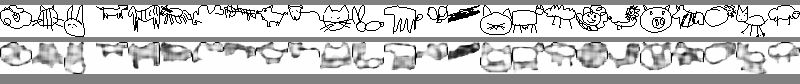

In [18]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))

